In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, precision_score, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib



# Predicción

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_original = pd.read_csv('/content/drive/MyDrive/Mis estudios /SIC /Reto/jobs_in_data.csv')
df = df_original.copy()

In [10]:
df

,work_year,job_title,job_category,salary_currency,salary,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_location,company_size
0,2023,Data DevOps Engineer,Data Engineering,EUR,88000,95012,Germany,Mid-level,Full-time,Hybrid,Germany,L
1,2023,Data Architect,Data Architecture and Modeling,USD,186000,186000,United States,Senior,Full-time,In-person,United States,M
2,2023,Data Architect,Data Architecture and Modeling,USD,81800,81800,United States,Senior,Full-time,In-person,United States,M
3,2023,Data Scientist,Data Science and Research,USD,212000,212000,United States,Senior,Full-time,In-person,United States,M
4,2023,Data Scientist,Data Science and Research,USD,93300,93300,United States,Senior,Full-time,In-person,United States,M
...,...,...,...,...,...,...,...,...,...,...,...,...
9350,2021,Data Specialist,Data Management and Strategy,USD,165000,165000,United States,Senior,Full-time,Remote,United States,L
9351,2020,Data Scientist,Data Science and Research,USD,412000,412000,United States,Senior,Full-time,Remote,United States,L
9352,2021,Principal Data Scientist,Data Science and Research,USD,151000,151000,United States,Mid-level,Full-time,Remote,United States,L
9353,2020,Data Scientist,Data Science and Research,USD,105000,105000,United States,Entry-level,Full-time,Remote,United States,S


In [11]:
df.columns

Index(['work_year', 'job_title', 'job_category', 'salary_currency', 'salary',
       'salary_in_usd', 'employee_residence', 'experience_level',
       'employment_type', 'work_setting', 'company_location', 'company_size'],
      dtype='object')

In [12]:
for column in df.columns:
    print(f"{column}: {df[column].dtype}")

work_year: int64
job_title: object
job_category: object
salary_currency: object
salary: int64
salary_in_usd: int64
employee_residence: object
experience_level: object
employment_type: object
work_setting: object
company_location: object
company_size: object


In [4]:
# Inflación de USA y la del mundo.
us_inflation_rates = {2019: 0.0181, 2020: 0.0123, 2021: 0.0470, 2022: 0.065}
global_inflation_rates = {2019: 0.0219, 2020: 0.0192, 2021: 0.0350, 2022: 0.088}

# Crear función para 'adjusted_salary'
def adjust_salary(row):
    year = row['work_year']
    original_salary = row['salary_in_usd']
    currency = row['salary_currency']

    if year == 2023:
        return original_salary

    adjusted_salary = original_salary
    for y in range(year, 2023):
        if currency == 'USD':
            inflation_rate = us_inflation_rates[y]
        else:
            inflation_rate = global_inflation_rates[y]

        adjusted_salary *= (1 + inflation_rate)

    return adjusted_salary

#Incorporar al dataset
df['salary_in_usd'] = df.apply(adjust_salary, axis=1)
df['salary_in_usd'] = df['salary_in_usd'].astype(int)

In [5]:
# Eliminar duplicados
# df = df.drop_duplicates().reset_index(drop=True)
df = df.drop(labels=['job_title','work_year','salary_currency','salary'], axis=1)
# df

In [6]:
def top_5 (categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map
country_map= top_5(df.company_location.value_counts() , 20)

df['company_location'] = df['company_location'].map(country_map)
df['employee_residence'] = df['employee_residence'].map(country_map)

display(df['company_location'].value_counts())
display(df['employee_residence'].value_counts())

company_location
United States     8132
United Kingdom     449
Other              244
Canada             226
Spain              113
Germany             72
France              50
Portugal            24
Australia           24
Netherlands         21
Name: count, dtype: int64

employee_residence
United States     8086
United Kingdom     442
Other              277
Canada             224
Spain              117
Germany             66
France              54
Portugal            26
Netherlands         21
Australia           21
Name: count, dtype: int64

In [ ]:
# def detectar_atipicos(df, salario, pais_empresa):

#     subconjunto = df[df['company_location'] == pais_empresa][salario]

#     Q1 = subconjunto.quantile(0.25)
#     Q3 = subconjunto.quantile(0.75)
#     IQR = Q3 - Q1

#     atipicos = df[(df['company_location'] == pais_empresa) & ((df[salario] < Q1 - 1.5 * IQR) | (df[salario] > Q3 + 1.5 * IQR))]

#     return atipicos

# paises = ['United States', 'Other', 'United Kingdom']

# for p in paises:
#   atip= detectar_atipicos(df, 'salary_in_usd', p)
#   df.drop(atip.index, inplace=True)

#   df_winsore = df.copy()

In [ ]:
df

,job_category,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_location,company_size
0,Data Engineering,95012,Germany,Mid-level,Full-time,Hybrid,Germany,L
1,Data Architecture and Modeling,186000,United States,Senior,Full-time,In-person,United States,M
2,Data Architecture and Modeling,81800,United States,Senior,Full-time,In-person,United States,M
3,Data Science and Research,212000,United States,Senior,Full-time,In-person,United States,M
4,Data Science and Research,93300,United States,Senior,Full-time,In-person,United States,M
...,...,...,...,...,...,...,...,...
9350,Data Management and Strategy,183984,United States,Senior,Full-time,Remote,United States,L
9351,Data Science and Research,465053,United States,Senior,Full-time,Remote,United States,L
9352,Data Science and Research,168373,United States,Mid-level,Full-time,Remote,United States,L
9353,Data Science and Research,118520,United States,Entry-level,Full-time,Remote,United States,S


In [8]:
# Eliminar atípicos
df_winsore = df.copy()

def remove_outliers(df, column, lower_quantile=0.15, upper_quantile=0.75):
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Definir la función para eliminar los valores atípicos

# def remove_outliers(df, column, lower_quantile=0.25, upper_quantile=0.75):
#     lower_bound = df[column].quantile(lower_quantile)
#     upper_bound = df[column].quantile(upper_quantile)
#     IQR = upper_bound - lower_bound
#     max_bound = upper_bound + (1.2*IQR)
#     min_bound = lower_bound - (1.2*IQR)
#     return df[(df[column] >= min_bound) & (df[column] <= max_bound)]

# Suponiendo que df_winsore ya está definido y tiene las columnas correspondientes
df_cleaned = pd.DataFrame()  # DataFrame para almacenar los datos limpiados

for job_category in df_winsore['job_category'].value_counts().index.to_list():
    for experience_level in df_winsore['experience_level'].value_counts().index.to_list():
        for employment_type in df_winsore['employment_type'].value_counts().index.to_list():
            # Filtrar el DataFrame para obtener los datos específicos
            mask = (df_winsore['job_category'] == job_category) & \
                   (df_winsore['experience_level'] == experience_level) & \
                   (df_winsore['employment_type'] == employment_type)
            subset_df = df_winsore[mask]
            try:
                # Eliminar valores atípicos
                cleaned_subset_df = remove_outliers(subset_df, 'salary_in_usd')
                df_cleaned = pd.concat([df_cleaned, cleaned_subset_df])
            except Exception as e:
                print(f"Error processing {job_category}, {experience_level}, {employment_type}: {e}")

# Reemplazar el DataFrame original con los datos limpiados
df_winsore = df_cleaned.reset_index(drop=True)

display(df_winsore)

,job_category,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_location,company_size
0,Data Science and Research,130000,United States,Senior,Full-time,Remote,United States,M
1,Data Science and Research,127300,United States,Senior,Full-time,In-person,United States,L
2,Data Science and Research,186200,United States,Senior,Full-time,Remote,United States,M
3,Data Science and Research,185900,United States,Senior,Full-time,In-person,United States,M
4,Data Science and Research,129300,United States,Senior,Full-time,In-person,United States,M
...,...,...,...,...,...,...,...,...
5678,Data Quality and Operations,63900,United States,Mid-level,Full-time,Remote,United States,M
5679,Data Quality and Operations,36912,United Kingdom,Entry-level,Full-time,Remote,United Kingdom,M
5680,Cloud and Database,170000,United States,Senior,Full-time,Remote,United States,L
5681,Cloud and Database,140000,United States,Senior,Full-time,Remote,United States,M


<Axes: xlabel='experience_level', ylabel='salary_in_usd'>

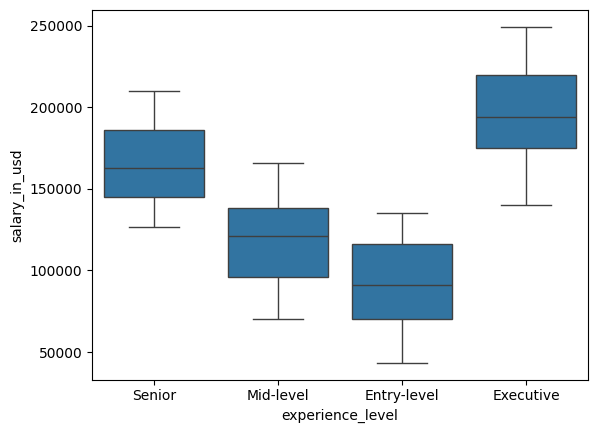

In [9]:
sns.boxplot(data=df_winsore[(df_winsore['job_category'] == 'Data Science and Research') & (df_winsore['employment_type'] == 'Full-time')],y='salary_in_usd',x='experience_level')

<Axes: xlabel='experience_level', ylabel='salary_in_usd'>

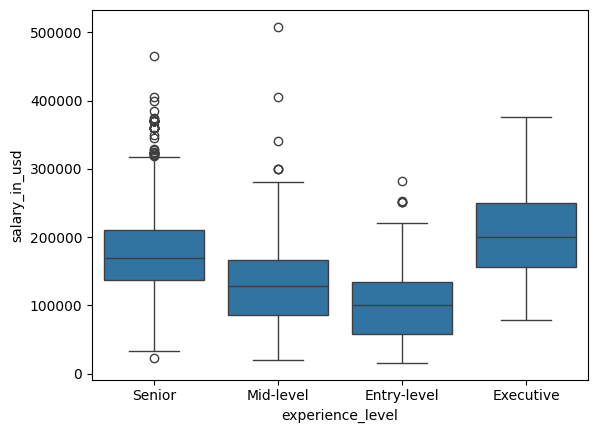

In [10]:
sns.boxplot(data=df[(df['job_category'] == 'Data Science and Research') & (df['employment_type'] == 'Full-time')],y='salary_in_usd',x='experience_level')

In [26]:
# LabelEncoder()
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

df_procesado = df_winsore.copy()

encoders = {'experience_level':LabelEncoder()}
encoders['experience_level'].classes_ = np.array(list({'Entry-level': 0, 'Mid-level': 1, 'Senior': 2, 'Executive': 3}.keys()))
df_procesado['experience_level'] = encoders['experience_level'].transform(df_procesado['experience_level'])

encoders['company_size'] = LabelEncoder()
encoders['company_size'].classes_ = np.array(list({'S': 0, 'M': 1, 'L': 2}.keys()))
df_procesado['company_size'] = encoders['company_size'].transform(df_procesado['company_size'])

for column in ['job_category','employee_residence','employment_type','work_setting','company_location']:
    encoders[column] = LabelEncoder()
    df_procesado[column] = encoders[column].fit_transform(df_procesado[column])

#### Exportando el LabelEncoder

In [27]:
joblib.dump(encoders,'label_encoders_regressor.joblib')

['label_encoders_regressor.joblib']

In [ ]:
display(df_procesado)
display(df_winsore)

,job_category,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_location,company_size
0,7,130000,9,2,2,2,9,1
1,7,127300,9,2,2,1,9,2
2,7,186200,9,2,2,2,9,1
3,7,185900,9,2,2,1,9,1
4,7,129300,9,2,2,1,9,1
...,...,...,...,...,...,...,...,...
5678,6,63900,9,1,2,2,9,1
5679,6,36912,8,0,2,2,8,1
5680,1,170000,9,2,2,2,9,2
5681,1,140000,9,2,2,2,9,1


,job_category,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_location,company_size
0,Data Science and Research,130000,United States,Senior,Full-time,Remote,United States,M
1,Data Science and Research,127300,United States,Senior,Full-time,In-person,United States,L
2,Data Science and Research,186200,United States,Senior,Full-time,Remote,United States,M
3,Data Science and Research,185900,United States,Senior,Full-time,In-person,United States,M
4,Data Science and Research,129300,United States,Senior,Full-time,In-person,United States,M
...,...,...,...,...,...,...,...,...
5678,Data Quality and Operations,63900,United States,Mid-level,Full-time,Remote,United States,M
5679,Data Quality and Operations,36912,United Kingdom,Entry-level,Full-time,Remote,United Kingdom,M
5680,Cloud and Database,170000,United States,Senior,Full-time,Remote,United States,L
5681,Cloud and Database,140000,United States,Senior,Full-time,Remote,United States,M


In [44]:
df_procesado['salary_in_usd'].std()

39385.79880196725

In [43]:
# Variables label

X = df_procesado.drop(['salary_in_usd'],axis=1)

Y = df_procesado[['salary_in_usd']]
scaler = StandardScaler()
Y = scaler.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,
test_size=0.33,random_state=42,stratify=df_procesado['company_location'])

display(X_train)
display(Y_train)

,job_category,employee_residence,experience_level,employment_type,work_setting,company_location,company_size
904,7,9,2,2,1,9,1
3610,2,9,2,2,1,9,1
1927,4,9,2,2,1,9,1
1896,4,9,2,2,2,9,1
598,7,9,2,2,1,9,1
...,...,...,...,...,...,...,...
4484,9,9,2,2,2,9,1
4566,9,9,2,2,1,9,1
785,7,9,2,2,2,9,1
5305,0,9,2,2,1,9,1


array([[ 1.59410317],
       [-0.86131254],
       [-0.65309735],
       ...,
       [ 1.50523083],
       [ 0.9170991 ],
       [-1.6986423 ]])

## XGboost

In [13]:

params_xgb = {
    'n_estimators': [40,70,100,120,150],
    'max_depth': [4, 6,8,10],
    'gamma': [0.0001,0.1,0.03, 0.05 ,0.1, 1],
    'grow_policy': ['depthwise', 'lossguide'],  # Corrige el valor de grow_policy
    'max_leaves': [3,7,9,11],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9 ]
}

grid_xgb = GridSearchCV(XGBRegressor(),params_xgb,cv=5,n_jobs=-1)
grid_xgb.fit(X_train,Y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'gamma': [0.0001, 0.1, 0.03, 0.05, 0.1, 1],
                         'grow_policy': ['depthwise', 'lossguide'],
                         'max_depth': [4, 6, 8, 10],
                         'max_leaves': [3, 7, 9, 11],
                         'n_estimators': [40, 70, 100, 120, 150]})

In [14]:
xgboost = XGBRegressor(**grid_xgb.best_params_)
xgboost.fit(X_train,Y_train)
y_xgb = xgboost.predict(X_test)

In [22]:
joblib.dump(xgboost,'xgboost_regressor.pkl')

['xgboost_regressor.pkl']

In [16]:
np.round(r2_score(Y_test,y_xgb),4)

0.6426

In [18]:
from sklearn.metrics import mean_squared_error

In [23]:
error = np.sqrt(mean_squared_error(Y_test, y_xgb))
print("${:,.02f}".format(error))

print(mean_squared_error(Y_test, y_xgb))

0.3452426683041733
$0.59


### Para probar el modelo de regresión

In [24]:
def predictRegression(x_prueba, modelo,encoder):

    transformed_array = []
    for value,column in zip(x_prueba,['job_category','employee_residence','experience_level','employment_type',
                                      'company_location','work_setting','company_size']):
        transformed_value = encoder[column].transform([value])[0]
        transformed_array.append(transformed_value)


    transformed_array
    y_pred = modelo.predict(np.array(transformed_array).reshape(1, -1))
    print(scaler.inverse_transform([y_pred]))

In [37]:
X_prueba = ['Data Analysis','United Kingdom','Mid-level','Contract','Other','In-person','M']

xgb_regressor = joblib.load("xgboost_regressor.pkl")
label_encoder_r = joblib.load("label_encoders_regressor.joblib")

predictRegression(X_prueba,xgb_regressor,label_encoder_r)

[[79793.64072932]]


In [ ]:
#Probando el modelo con nuevos datos

X_prueba = ['Data Science and Research','United States','Executive','Full-time','United Kingdom','In-person','L']
X_prueba

transformed_array = []
for value,column in zip(X_prueba,['job_category','employee_residence',
'experience_level','employment_type','company_location','work_setting','company_size']):
  transformed_value = encoders[column].transform([value])[0]
  transformed_array.append(transformed_value)


transformed_array
y_pred = xgboost.predict(np.array(transformed_array).reshape(1, -1))
scaler.inverse_transform([y_pred])

array([[196549.13112326]])

#### Otros modelos de regresión

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

Gradient_boost = GradientBoostingRegressor(n_estimators=1000, max_depth=7,  subsample=0.7)
Gradient_boost.fit(X_train , Y_train)
y_pred = Gradient_boost.predict(X_test)
print(mean_squared_error(Y_test, y_pred))
print(r2_score(Y_test, y_pred))



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.3594134726242287
0.6279397058934657


In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

RFReg = RandomForestRegressor(max_depth=2, random_state=0)
RFReg.fit(X_train , Y_train.ravel())
y_pred = RFReg.predict(X_test)

print(r2_score(Y_test, y_pred))
print(mean_squared_error(Y_test, y_pred))

0.5303520612610981
0.4536839841464695


In [56]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train , Y_train)
y_pred = lr.predict(X_test)


print(r2_score(Y_test, y_pred))
print(mean_squared_error(Y_test, y_pred))

0.5391617891052476
0.44517371060345756


In [57]:
from sklearn.ensemble import AdaBoostRegressor
AdaBoost = AdaBoostRegressor(random_state=0, n_estimators=100)
AdaBoost.fit(X_train , Y_train)
y_pred = AdaBoost.predict(X_test)

print(AdaBoost.score(X_test, y_pred))
print(r2_score(Y_test, y_pred))
print(mean_squared_error(Y_test, y_pred))

1.0
0.5585149761807923
0.42647836395306715


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
nombres.get('Mid-level')

In [ ]:
nombres

{'experience_level': [['Entry-level', 1],
  ['Mid-level', 2],
  ['Senior', 3],
  ['Executive', 4]],
 'company_size': [['S', 1], ['M', 2], ['L', 3]]}

In [ ]:
lista = zip(X_prueba,['job_category','employee_residence','employment_type','work_setting','company_location'])

TypeError: 'zip' object is not subscriptable

# Clasificación país

In [58]:
df_original = pd.read_csv('/content/drive/MyDrive/Mis estudios /SIC /Reto/jobs_in_data.csv')
df = df_original.copy()

In [59]:
# Inflación de USA y la del mundo.
us_inflation_rates = {2019: 0.0181, 2020: 0.0123, 2021: 0.0470, 2022: 0.065}
global_inflation_rates = {2019: 0.0219, 2020: 0.0192, 2021: 0.0350, 2022: 0.088}

# Crear función para 'adjusted_salary'
def adjust_salary(row):
    year = row['work_year']
    original_salary = row['salary_in_usd']
    currency = row['salary_currency']

    if year == 2023:
        return original_salary

    adjusted_salary = original_salary
    for y in range(year, 2023):
        if currency == 'USD':
            inflation_rate = us_inflation_rates[y]
        else:
            inflation_rate = global_inflation_rates[y]

        adjusted_salary *= (1 + inflation_rate)

    return adjusted_salary

#Incorporar al dataset
df['salary_in_usd'] = df.apply(adjust_salary, axis=1)
df['salary_in_usd'] = df['salary_in_usd'].astype(int)

In [60]:
df = df.drop(labels=['job_title','work_year','salary_currency','salary'], axis=1)


In [62]:
def top_5 (categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map
country_map= top_5(df.company_location.value_counts() , 20)

df['company_location'] = df['company_location'].map(country_map)
df['employee_residence'] = df['employee_residence'].map(country_map)

display(df['company_location'].value_counts())
display(df['employee_residence'].value_counts())

company_location
United States     8132
United Kingdom     449
Other              244
Canada             226
Spain              113
Germany             72
France              50
Portugal            24
Australia           24
Netherlands         21
Name: count, dtype: int64

employee_residence
United States     8086
United Kingdom     442
Other              277
Canada             224
Spain              117
Germany             66
France              54
Portugal            26
Netherlands         21
Australia           21
Name: count, dtype: int64

In [ ]:
df

,job_category,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_location,company_size
0,Data Engineering,95012,Germany,Mid-level,Full-time,Hybrid,Germany,L
1,Data Architecture and Modeling,186000,United States,Senior,Full-time,In-person,United States,M
2,Data Architecture and Modeling,81800,United States,Senior,Full-time,In-person,United States,M
3,Data Science and Research,212000,United States,Senior,Full-time,In-person,United States,M
4,Data Science and Research,93300,United States,Senior,Full-time,In-person,United States,M
...,...,...,...,...,...,...,...,...
5336,Data Management and Strategy,183984,United States,Senior,Full-time,Remote,United States,L
5337,Data Science and Research,465053,United States,Senior,Full-time,Remote,United States,L
5338,Data Science and Research,168373,United States,Mid-level,Full-time,Remote,United States,L
5339,Data Science and Research,118520,United States,Entry-level,Full-time,Remote,United States,S


In [63]:
# Eliminar atípicos
df_winsore = df.copy()

def remove_outliers(df, column, lower_quantile=0.10, upper_quantile=0.90):
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Definir la función para eliminar los valores atípicos

# def remove_outliers(df, column, lower_quantile=0.25, upper_quantile=0.75):
#     lower_bound = df[column].quantile(lower_quantile)
#     upper_bound = df[column].quantile(upper_quantile)
#     IQR = upper_bound - lower_bound
#     max_bound = upper_bound + (1.2*IQR)
#     min_bound = lower_bound - (1.2*IQR)
#     return df[(df[column] >= min_bound) & (df[column] <= max_bound)]

# Suponiendo que df_winsore ya está definido y tiene las columnas correspondientes
df_cleaned = pd.DataFrame()  # DataFrame para almacenar los datos limpiados

for job_category in df_winsore['job_category'].value_counts().index.to_list():
    for experience_level in df_winsore['experience_level'].value_counts().index.to_list():
        for employment_type in df_winsore['employment_type'].value_counts().index.to_list():
            # Filtrar el DataFrame para obtener los datos específicos
            mask = (df_winsore['job_category'] == job_category) & \
                   (df_winsore['experience_level'] == experience_level) & \
                   (df_winsore['employment_type'] == employment_type)
            subset_df = df_winsore[mask]
            try:
                # Eliminar valores atípicos
                cleaned_subset_df = remove_outliers(subset_df, 'salary_in_usd')
                df_cleaned = pd.concat([df_cleaned, cleaned_subset_df])
            except Exception as e:
                print(f"Error processing {job_category}, {experience_level}, {employment_type}: {e}")

# Reemplazar el DataFrame original con los datos limpiados
df_winsore = df_cleaned.reset_index(drop=True)

display(df_winsore)

,job_category,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_location,company_size
0,Data Science and Research,212000,United States,Senior,Full-time,In-person,United States,M
1,Data Science and Research,130000,United States,Senior,Full-time,Remote,United States,M
2,Data Science and Research,234000,United States,Senior,Full-time,In-person,United States,M
3,Data Science and Research,247600,United States,Senior,Full-time,In-person,United States,L
4,Data Science and Research,127300,United States,Senior,Full-time,In-person,United States,L
...,...,...,...,...,...,...,...,...
7482,Data Quality and Operations,63900,United States,Mid-level,Full-time,Remote,United States,M
7483,Data Quality and Operations,36912,United Kingdom,Entry-level,Full-time,Remote,United Kingdom,M
7484,Cloud and Database,170000,United States,Senior,Full-time,Remote,United States,L
7485,Cloud and Database,140000,United States,Senior,Full-time,Remote,United States,M


In [64]:
df_procesado = df_winsore.copy()

encoders = {}

# Aplicar LabelEncoder a cada columna categórica
for column in ['job_category','employee_residence','experience_level','employment_type', 'work_setting','company_location','company_size']:
    encoders[column] = LabelEncoder()
    df_procesado[column] = encoders[column].fit_transform(df_procesado[column])

# for column in ['job_category','employee_residence','experience_level','employment_type', 'work_setting','company_location','company_size']:
#   df_procesado[column] = le.fit_transform(df_procesado[column])

In [ ]:
encoders

{'job_category': LabelEncoder(),
 'employee_residence': LabelEncoder(),
 'experience_level': LabelEncoder(),
 'employment_type': LabelEncoder(),
 'work_setting': LabelEncoder(),
 'company_location': LabelEncoder(),
 'company_size': LabelEncoder()}

In [ ]:
joblib.dump(encoders,'label_encoders_classifier.joblib')

['label_encoders_classifier.joblib']

In [ ]:
df_procesado

,job_category,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_location,company_size
0,7,212000,15,3,2,1,15,1
1,7,130000,15,3,2,2,15,1
2,7,234000,15,3,2,1,15,1
3,7,247600,15,3,2,1,15,0
4,7,127300,15,3,2,1,15,0
...,...,...,...,...,...,...,...,...
4230,6,63900,15,2,2,2,15,1
4231,6,36912,14,0,2,2,14,1
4232,1,170000,15,3,2,2,15,0
4233,1,140000,15,3,2,2,15,1


In [65]:
X = df_procesado.drop(['company_location'],axis=1)
Y = df_procesado['company_location']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.33,random_state=42)

display(X_train)
display(Y_train)

,job_category,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_size
3341,4,133300,9,3,2,1,1
1825,7,180000,9,2,2,1,1
5632,9,150000,9,3,2,2,1
1094,7,219000,9,3,2,1,1
5244,2,53250,9,2,2,2,1
...,...,...,...,...,...,...,...
5191,2,63900,9,2,2,2,1
5226,2,79875,9,2,2,1,1
5390,9,204500,9,3,2,1,1
860,7,192000,9,3,2,2,1


3341    9
1825    9
5632    9
1094    9
5244    9
       ..
5191    9
5226    9
5390    9
860     9
7270    9
Name: company_location, Length: 5016, dtype: int64

In [ ]:
#pd.concat([pd.DataFrame(le.inverse_transform(Y),columns=['Nombre']),pd.DataFrame(Y,columns=['numero'])],axis=1)

### XGBClass

In [ ]:
param_xgbc = {
    'n_estimators': [100,200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [4, 5, 6],
    'min_child_weight': [1, 3],
    'gamma': [0.2, 0.3],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.8, 1.0]
}

In [ ]:
from sklearn.model_selection import StratifiedKFold

grid_xgbc = GridSearchCV(XGBClassifier(),param_xgbc,cv=StratifiedKFold(n_splits=5),n_jobs=-1)
grid_xgbc.fit(X_train,Y_train)


c:\Users\nicol\miniconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0.2, 0.3],
                         'learning_rate': [0.1, 0.2], 'max_depth': [4, 5, 6],
                         'min_child_weight': [1, 3], 'n_estimators': [100, 200],
                         'subsample': [0.6, 0.8]})

In [ ]:
xgbc = XGBClassifier(**grid_xgbc.best_params_)
xgbc.fit(X_train,Y_train)
round(xgbc.score(X_test,Y_test),4)

0.9907

In [ ]:
joblib.dump(xgbc,'xgboost_classifier.pkl')

['xgboost_classifier.pkl']

In [ ]:
from sklearn.metrics import f1_score, recall_score

print(f"Macro: {f1_score(Y_test,xgbc.predict(X_test),average='macro')}")
print(f"Micro: {f1_score(Y_test,xgbc.predict(X_test),average='micro')}")
print(f"Weighted: {f1_score(Y_test,xgbc.predict(X_test),average='weighted')}")

Macro: 0.9085638478222493
Micro: 0.990692027519223
Weighted: 0.9907703745930548


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,xgbc.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       1.00      1.00      1.00         3
           2       0.98      1.00      0.99        52
           3       1.00      1.00      1.00         1
           4       0.91      0.77      0.83        13
           5       0.90      1.00      0.95        19
           6       0.00      0.00      0.00         2
           8       1.00      1.00      1.00         1
           9       1.00      0.86      0.92         7
          10       0.63      0.85      0.72        20
          12       1.00      0.50      0.67         2
          13       0.86      1.00      0.92         6
          14       1.00      0.99      0.99        83
          15       1.00      0.99      0.99      1182

    accuracy                           0.99      1398
   macro avg       0.88      0.84      0.85      1398
weighted avg       0.99      0.99      0.99      1398



c:\Users\nicol\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nicol\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nicol\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Tree (15% más eficiente que el XG)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],  # Función para medir la calidad de una división
    'splitter': ['best', 'random'],    # Estrategia utilizada para dividir en cada nodo
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],      # Número mínimo de muestras necesarias para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 6],      # Número mínimo de muestras necesarias para estar en una hoja
    'max_features': [None, 'sqrt', 'log2'],   # Número de características a considerar cuando se busca la mejor división
    'max_leaf_nodes': [None, 10, 20, 30],     # Número máximo de nodos hoja en el árbol
    'min_impurity_decrease': [0.0, 0.01, 0.1], # Umbral para reducir la impureza
    'class_weight': [None, 'balanced']        # Ponderaciones asociadas con las clases
}

grid_dtc = GridSearchCV(DecisionTreeClassifier(),param_grid=param_grid,cv=5,n_jobs=-1)
grid_dtc.fit(X_train,Y_train)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train,Y_train)

DecisionTreeClassifier()

In [ ]:
tree_predictions = dtc.predict(X_test)

In [ ]:
X_train

,job_category,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_size
2488,9,283780,15,3,2,1,1
3162,2,140700,15,3,2,2,1
3193,2,112000,15,3,2,2,1
3974,0,93000,15,3,2,2,1
1718,4,96100,15,3,2,2,1
...,...,...,...,...,...,...,...
3444,2,61200,15,2,2,1,1
466,7,167560,15,3,2,2,1
3092,2,169000,15,3,2,1,1
3772,8,191700,15,3,2,1,1


In [ ]:
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score


print(recall_score(Y_test, tree_predictions, average = 'macro')) #El indicador de Recall, que es el de acierto de verdaderos, es similar al F1Score(ponderados con Macro)
print(accuracy_score(Y_test, tree_predictions))

0.8628955783637132
0.9799713876967096


c:\Users\nicol\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(f1_score(Y_test, tree_predictions, average='micro'))
print(f1_score(Y_test, tree_predictions, average='macro')) #Macro es la que debemos tener en cuenta porque es la mejor para datasets desbalanceados
print(f1_score(Y_test, tree_predictions, average='weighted'))

0.9890732496964791
0.888356447444603
0.9889941560596452


In [ ]:
def predictClassification(x_prueba, modelo,encoder,salario=np.nan):

    transformed_array = []
    for value,column in zip(x_prueba,['job_category','employee_residence','experience_level','employment_type', 'work_setting','company_size']):
        transformed_value = encoder[column].transform([value])[0]
        transformed_array.append(transformed_value)

    transformed_array.insert(1,salario)
    y_pred = modelo.predict(np.array(transformed_array).reshape(1, -1))
    print(encoder['company_location'].inverse_transform(y_pred)[0])

In [ ]:
X_prueba = ['Data Engineering','United States', 'Mid-level', 'Full-time','Remote', 'M']

xgb_classifier = joblib.load("xgboost_classifier.pkl")
label_encoder_c = joblib.load("label_encoders_classifier.joblib")

predictClassification(X_prueba,xgb_classifier,label_encoder_c,120000)

United States


In [ ]:
#Probando el modelo con nuevos datos

X_prueba = ['Data Engineering','Germany', 'Mid-level', 'Full-time','Remote', 'M']
X_prueba

transformed_array = []
for value,column in zip(X_prueba,['job_category','employee_residence','experience_level','employment_type', 'work_setting','company_size']):
  transformed_value = encoders[column].transform([value])[0]
  transformed_array.append(transformed_value)

transformed_array.insert(1,112000)
y_pred = dtc.predict(np.array(transformed_array).reshape(1, -1))
encoders['company_location'].inverse_transform(y_pred)[0]

c:\Users\nicol\miniconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


'United States'

In [ ]:

y_pred = clf.predict(X.reshape(1, -1))
y_pred

df_procesado['company_location'] = le.inverse_transform(y_pred)
print(df)

Por ejecutar para probar: el siguiente GridSearch para RandomForest

In [ ]:
# n_estimators_grid = np.arange(20, 200,2)
# depth_grid = np.arange(1, 10,1)
# min_samples_leaf_grid = np.arange(2,21,2)
# parameters = {'n_estimators': n_estimators_grid, 'max_depth': depth_grid, 'min_samples_leaf':min_samples_leaf_grid}
# gridCV = GridSearchCV(RandomForestClassifier(), param_grid=parameters, cv=10, n_jobs=-1)
# gridCV.fit(X_train, Y_train)
# best_n_estim = gridCV.best_params_['n_estimators']
# best_depth = gridCV.best_params_['max_depth']
# best_min_samples_leaf = gridCV.best_params_['min_samples_leaf']

c:\Users\nicol\miniconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


In [ ]:
RF_best = RandomForestClassifier(n_estimators=30,max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,random_state=123)
RF_best.fit(X_train, Y_train)
Y_pred = RF_best.predict(X_test)
print( "Mejor f1_score (weighted) de Random Forest: " + str(np.round(f1_score(Y_test,Y_pred, average = 'macro'),3)))
print( "Mejor recall (weighted) de Random Forest: " + str(np.round(recall_score(Y_test,Y_pred, average = 'weighted'),3)))

Mejor f1_score (weighted) de Random Forest: 0.336
Mejor recall (weighted) de Random Forest: 0.959


In [ ]:
encoders['job_category'].classes_

array(['BI and Visualization', 'Cloud and Database', 'Data Analysis',
       'Data Architecture and Modeling', 'Data Engineering',
       'Data Management and Strategy', 'Data Quality and Operations',
       'Data Science and Research', 'Leadership and Management',
       'Machine Learning and AI'], dtype=object)

In [1]:
!jupyter nbconvert --execute --to html "/content/ashtemel.ipynb"

[NbConvertApp] Converting notebook /content/ashtemel.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 560, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 4